## 1. 데이터 준비

In [1]:
%matplotlib inline
# Standard library imports
import datetime
import os
from copy import deepcopy
import pickle

# Third-party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import random
from itertools import combinations

# from IPython.display import clear_output
from scipy.spatial import distance
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms

# Local application/library specific imports
from data_utils import (generate_server_idcs, CustomSubset, split_3class_unbalanced, split_contain_multiclass,
                        split_7plus3class_unbalanced, CombinedCustomSubset)
from fl_devices import Server, Client
from helper import ExperimentLogger, display_train_stats
from models import ConvNet, Representation, Two_class_classifier, Ten_class_classifier, Four_class_classifier


torch.manual_seed(42)
np.random.seed(42)

In [2]:
LOCAL_EPOCHS = 25
N_CLIENTS = 6
NUMBER_OF_CLUSTER = 3
ALPHA = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# data = datasets.CIFAR10(root="CIFAR10/", download=False)
data = datasets.MNIST(root="MNIST/", download=False)
idcs = np.random.permutation(len(data))

def cluster(server, clients, number_of_cluster):
    label_predicted = pd.DataFrame()
    # label_acc = pd.DataFrame()
    for i, client in enumerate(clients):
        pred = server.check_cluster(client.model)
        # print(f'pred: {pred}')
        label_predicted = pd.concat([label_predicted, pd.DataFrame(pred, index=[i])])
        # label_acc = pd.concat([label_acc, pd.DataFrame(acc, index=[i])])
    label_predicted.reset_index(drop=True, inplace=True)
    label_predicted.fillna(0, inplace=True)
    
    print(f'predicted label')
    print(label_predicted)

    cluster_idcs, number_of_cluster= server.cluster_clients(label_predicted)
    return label_predicted, cluster_idcs, number_of_cluster



def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


def get_cluster_weights(cluster_logits, cluster_weight_per_class):
    # Step 1: Find the class with the maximum value in each logit in cluster_logits
    # Assuming the dimension for classes is the second one
    max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
    print(max_classes)
    cluster_weights = []
    #c luster별로 
    for i, iogits in enumerate(cluster_logits):
        weights = []
        for j, logit in enumerate(logits):
            
            # print(f'max_classes: {max_classes[i][j]}')
            # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
            weights.append(max_classes[i][j])
        print(weights)
        cluster_weights.append(weights)

def visualize_clusters(label_predicted, real_cluster_distribution):
    # Reduce the dimension of the data
    pca = PCA(n_components=2)
    label_predicted_pca = pca.fit_transform(label_predicted)
    
    # Define colors for the clusters
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Calculate the number of samples in each real cluster
    n_samples = len(label_predicted)
    real_cluster_sizes = [int(n_samples * dist) for dist in real_cluster_distribution]

    # Plot the clusters
    plt.figure(figsize=(8, 5))

    start_idx = 0  # To keep track of the start index of each real cluster
    for i, size in enumerate(real_cluster_sizes):
        end_idx = start_idx + size  # Calculate the end index for this real cluster
        color = colors[i % len(colors)]  # Determine the color for this real cluster

        # Scatter plot for points belonging to this real cluster
        for j in range(start_idx, end_idx):
            plt.scatter(label_predicted_pca[j, 0], label_predicted_pca[j, 1], c=color, s=50, label=f'Real Cluster {i+1}' if j == start_idx else "")

        start_idx = end_idx  # Update the start index for the next real cluster
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize='large')

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    plt.show()

#     # Print the real cluster distribution
#     print("Real cluster distribution:", real_cluster_distribution)

#     # Calculate and print each client's cluster identity based on the real_cluster_distribution
#     n_clients = len(label_predicted)
#     cumulative_distribution = [0] + [sum(real_cluster_distribution[:i+1]) for i in range(len(real_cluster_distribution))]
#     client_cluster_id_real = [next((i for i, val in enumerate(cumulative_distribution) if val > client_idx / n_clients), -1) - 1 for client_idx in range(n_clients)]

#     print("Real cluster identity for each client:", client_cluster_id_real)

#     # Print each client's cluster identity based on the clusters argument
#     client_cluster_id_predicted = [next((i for i, cluster in enumerate(clusters) if client_idx in cluster), -1) for client_idx in range(n_clients)]
#     print("Predicted cluster identity for each client:", client_cluster_id_predicted)




def test_acc(server, clients, cluster_distribution):
    
    # Get individual client accuracies
    acc_clients = [client.evaluate() for client in clients]

    # Compute the average accuracy for each client
    client_acc = round(sum(acc_clients) / len(acc_clients), 3) if len(acc_clients) > 0 else 0

    # Compute cluster accuracies for this iteration
    cluster_accs_iteration = []
    start_idx = 0
    for distribution in cluster_distribution:
        end_idx = start_idx + int(distribution * len(clients))
        cluster_acc = round(sum(acc_clients[start_idx:end_idx]) / (end_idx - start_idx) + 0.000001, 3)
        cluster_accs_iteration.append(cluster_acc)
        start_idx = end_idx

    # Compute global accuracy for this iteration
    accuracies = [server.evaluate_distil(client.classifier) for client in clients]
    global_acc = round(np.mean(accuracies), 3)
    
    return client_acc, cluster_accs_iteration, global_acc


def get_global_logits(client_logits):
    avg_logits = torch.mean(torch.stack(client_logits), dim=0)
    return avg_logits

# def get_cluster_logits(client_logits, cluster_idcs):
#     cluster_logits = []
#     for i, cluster in enumerate(cluster_idcs):
#         cluster_client_logits = [client_logits[i] for i in cluster]
#         avg_cluster_logits = torch.mean(torch.stack(cluster_client_logits), dim=0)
#         cluster_logits.append(avg_cluster_logits)
#     return cluster_logits


def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10

def compute_accuracy(global_logits, data_targets, server_idcs):
    """
    Compute accuracy of predictions based on global logits.

    Args:
    - global_logits (list of Tensors): Each Tensor represents the logits for a data instance, 
                                       and its size is the number of classes.
    - data_targets (list of ints): List of true labels for all data.
    - server_idcs (list of ints): Indices of data instances we're interested in.

    Returns:
    - accuracy (float): Computed accuracy.
    """
    true_labels = [data_targets[i] for i in server_idcs]
    
    correct_predictions = 0
    total_predictions = len(true_labels)

    for logits, label in zip(global_logits, true_labels):
        predicted_label = np.argmax(logits.cpu().numpy())  # Convert Tensor to numpy and get index of max value
        if predicted_label == label:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


def save_tensor_to_csv(tensor, filename):
    # Convert tensor to numpy array
    array = tensor.cpu().detach().numpy()
    
    # Save numpy array to CSV file
    np.savetxt(filename, array, delimiter=",")

# def get_cluster_weights(cluster_logits, cluster_weight_per_class):
#     # Step 1: Find the class with the maximum value in each logit in cluster_logits
#     # Assuming the dimension for classes is the second one
#     max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
#     print(max_classes)
#     cluster_weights = []
#     #c luster별로 
#     for i, iogits in enumerate(cluster_logits):
#         weights = []
#         for j, logit in enumerate(logits):
            
#             # print(f'max_classes: {max_classes[i][j]}')
#             # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
#             weights.append(max_classes[i][j])
#         print(weights)
#         cluster_weights.append(weights)


In [4]:
def BC_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x, weight_decay=0.1),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # For Fast experiment
    
    # 1. Classifier
    # for i, client in enumerate(clients):
    #     Total_data = CustomSubset(data, np.concatenate((server_idcs, client_idcs[i])), transforms.Compose([transforms.ToTensor()]))
    #     model = client.learn_representation(Total_data, client.model)


    print('train classifier')
    
    
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_binary_classifier(lr = 1e-3)
        client.train_classifier(lr = 1e-3)

    client_accs, cluster_accs, global_accs = test_acc(server, clients, cluster_distribution)
    print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
    
    print('get_global_logit')
    print("")
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logit = server.get_clients_logit_simclr(client.binary_classifier, client.classifier, client.major_class)
        client_logits.append(client_logit)
    

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    cluster_logits,  cluster_idcs = server.get_cluster_logits(client_logits, number_of_cluster)
    clustering_acc = server.evaluate_clustering(cluster_distribution, cluster_idcs)
    print(f'clustering_acc: {clustering_acc}')

    
    distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        distill_loaders.append(distill_loader)
        
    # 4.Distillation
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
   
    
        client.distill((distill_loaders[cluster_idx]))
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [5]:
# client_accs, cluster_accs, global_accs = SimCLR_distill_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3])


In [6]:
def make_global_logit(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    # print(f'client count: {len(clients)}')

    client_logits = []
    
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    return server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, client_acc, cluster_accs, global_acc

def get_clustering_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')
    
    return silhouette, ari

    cluster_distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        cluster_distill_loaders.append(distill_loader)
        
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
        
        client.distill((cluster_distill_loaders[cluster_idx]))
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def copy_classifiers(clients):
    classifiers_state = []
    for client in clients:
        classifier_state = client.classifier.state_dict()
        classifiers_state.append(classifier_state)
    return classifiers_state


In [7]:
def cluster_train_result_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instances_per_class_per_client
    )

    
    # print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
    
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
   
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    # print(f'acc after global distill: {client_accs[1]}, {cluster_accs[1]}, {global_accs[1]}')
    # print(f'acc after cluster distill: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

def get_combination(array_length, class_per_cluster):
    if class_per_cluster == 1:
        combinations = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
    elif class_per_cluster == 2:
        combinations = [[0,1], [2,3], [4,5], [6,7], [8,9], [0,5], [1,6], [2,7], [3,8], [4,9], [0,3], [1,4], [2,5], [6,8], [7,9], [0,4], [1,5], [2,9], [3,7], [8,6]]
    elif class_per_cluster == 3:
        combinations = [[0,1,2], [3,4,5], [6,7,8], [9,0,1], [2,3,4], [5,6,7], [8,9,0], [1,2,3], [4,5,6], [7,8,9]]
    elif class_per_cluster == 4:
        combinations = [[0,1,2,3],[4,5,6,7],[8,9,0,1],[2,3,4,5],[6,7,8,9],[2,4,6,8],[1,3,5,9],[0,3,6,9],[1,4,7,0],[2,5,8,1]]
    elif class_per_cluster == 5:
        combinations = [[0,1,2,3,4],[4,5,6,7,8],[8,9,0,1,2],[2,3,4,5,6],[6,7,8,9,0],[2,4,6,8,0],[1,3,5,7,9],[0,2,3,6,9],[1,4,6,7,0],[2,5,6,8,1]]
    else:
        return "Invalid class_per_cluster"
    
    return combinations[:array_length]


In [8]:
def clustering_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instances_per_class_per_client
    )

    silhouette, ari = get_clustering_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
   
    return silhouette, ari

def get_combination(array_length, class_per_cluster):
    if class_per_cluster == 1:
        combinations = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
    elif class_per_cluster == 2:
        combinations = [[0,1], [2,3], [4,5], [6,7], [8,9], [0,5], [1,6], [2,7], [3,8], [4,9], [0,3], [1,4], [2,5], [6,8], [7,9], [0,4], [1,5], [2,9], [3,7], [8,6]]
    elif class_per_cluster == 3:
        combinations = [[0,1,2], [3,4,5], [6,7,8], [9,0,1], [2,3,4], [5,6,7], [8,9,0], [1,2,3], [4,5,6], [7,8,9]]
    elif class_per_cluster == 4:
        combinations = [[0,1,2,3],[4,5,6,7],[8,9,0,1],[2,3,4,5],[6,7,8,9],[2,4,6,8],[1,3,5,9],[0,3,6,9],[1,4,7,0],[2,5,8,1]]
    elif class_per_cluster == 5:
        combinations = [[0,1,2,3,4],[4,5,6,7,8],[8,9,0,1,2],[2,3,4,5,6],[6,7,8,9,0],[2,4,6,8,0],[1,3,5,7,9],[0,2,3,6,9],[1,4,6,7,0],[2,5,6,8,1]]
    else:
        return "Invalid class_per_cluster"
    
    return combinations[:array_length]


In [ ]:
def model_clustering_exp(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution, data_per_class_3, data_per_class_7):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution, data_per_class_3, data_per_class_7)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(Representation, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    

    # 1. Train classifier
    for i, client in enumerate(clients):
        client.train_classifier(lr=1e-3)

    similarities = server.compute_pairwise_similarities(clients)
    # print('similarities')
    # print(type(similarities))
    # print(similarities)
    cluster_idcs = server.cluster_clients_KMeans(similarities, number_of_cluster)
    
    visualize_clusters(similarities, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(similarities, cluster_distribution, cluster_idcs)

    return silhouette, ari

cluster_count: 2, class_per_cluster: 2
Epoch 5 - Train Loss: 2.1287, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 1.5834, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 15 - Train Loss: 0.7964, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 20 - Train Loss: 0.6108, Train Accuracy: 51.43%, Eval Accuracy: 66.67%
Epoch 25 - Train Loss: 0.5217, Train Accuracy: 90.00%, Eval Accuracy: 83.33%
Epoch 30 - Train Loss: 0.4343, Train Accuracy: 90.00%, Eval Accuracy: 96.67%
Global Logit's Accuracy: 27.06%
label_predicted:         0       1       2       3    4    5    6    7    8    9
0  3784.0  1216.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  3485.0  1515.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  2434.0  2566.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  2419.0  2581.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  3381.0  1619.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
5     0.0     0.0  1674.0  3326.0  0.0  0.0  0.0  0.0  0.0  0.0
6  

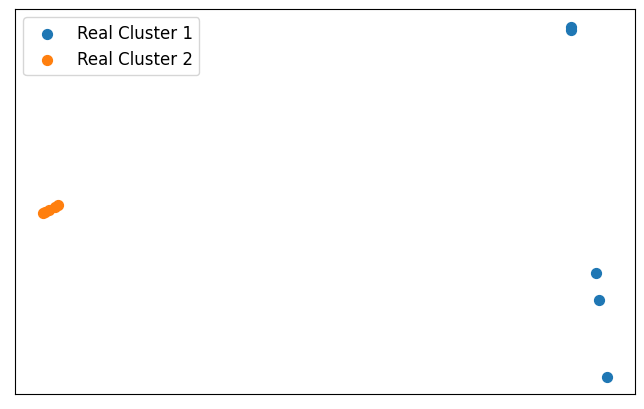

silhouette: 0.8218446969985962, ari: 1.0
cluster_count: 2, class_per_cluster: 3
Epoch 5 - Train Loss: 2.0889, Train Accuracy: 40.00%, Eval Accuracy: 33.33%
Epoch 10 - Train Loss: 1.4740, Train Accuracy: 33.33%, Eval Accuracy: 33.33%
Epoch 15 - Train Loss: 1.0390, Train Accuracy: 85.71%, Eval Accuracy: 53.33%
Epoch 20 - Train Loss: 0.9392, Train Accuracy: 76.19%, Eval Accuracy: 84.44%
Epoch 25 - Train Loss: 0.7835, Train Accuracy: 84.76%, Eval Accuracy: 84.44%
Epoch 30 - Train Loss: 0.5697, Train Accuracy: 91.43%, Eval Accuracy: 84.44%
Global Logit's Accuracy: 46.70%
label_predicted:         0       1       2       3       4       5    6    7    8    9
0  1669.0  1235.0  2096.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0
1  1020.0  1231.0  2749.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0
2  1382.0  1498.0  2120.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0
3  1300.0  1573.0  2127.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0
4  1007.0   951.0  3042.0     0.0     0.0     0.0  0.0  0.0 

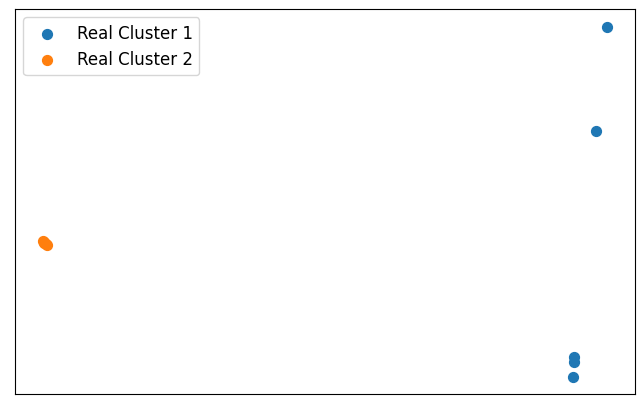

silhouette: 0.8544424772262573, ari: 1.0
cluster_count: 2, class_per_cluster: 4
Epoch 5 - Train Loss: 1.6476, Train Accuracy: 44.29%, Eval Accuracy: 38.33%
Epoch 10 - Train Loss: 1.1879, Train Accuracy: 65.00%, Eval Accuracy: 56.67%
Epoch 15 - Train Loss: 1.0338, Train Accuracy: 60.00%, Eval Accuracy: 73.33%
Epoch 20 - Train Loss: 0.6231, Train Accuracy: 93.57%, Eval Accuracy: 83.33%
Epoch 25 - Train Loss: 0.2049, Train Accuracy: 96.43%, Eval Accuracy: 91.67%
Epoch 30 - Train Loss: 0.1181, Train Accuracy: 95.71%, Eval Accuracy: 95.00%
Global Logit's Accuracy: 64.44%
label_predicted:        0      1       2       3       4       5       6       7    8    9
0  613.0  708.0  1293.0  2386.0     0.0     0.0     0.0     0.0  0.0  0.0
1  755.0  663.0  1547.0  2035.0     0.0     0.0     0.0     0.0  0.0  0.0
2  881.0  960.0  1540.0  1619.0     0.0     0.0     0.0     0.0  0.0  0.0
3  972.0  698.0  1626.0  1704.0     0.0     0.0     0.0     0.0  0.0  0.0
4  744.0  617.0  1310.0  2329.0     0.0 

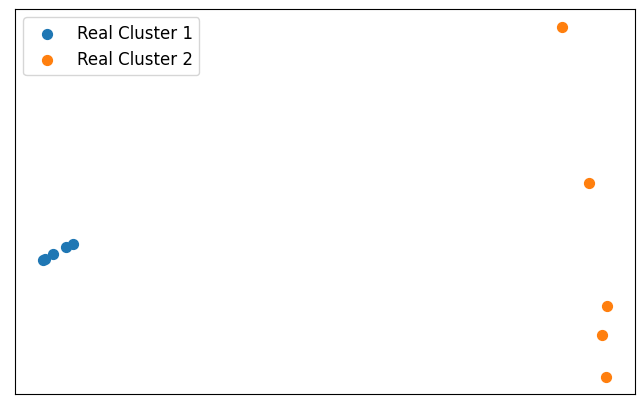

silhouette: 0.8124656677246094, ari: 1.0
cluster_count: 2, class_per_cluster: 5
Epoch 5 - Train Loss: 1.7512, Train Accuracy: 25.14%, Eval Accuracy: 24.00%
Epoch 10 - Train Loss: 1.2604, Train Accuracy: 82.29%, Eval Accuracy: 60.00%
Epoch 15 - Train Loss: 0.7925, Train Accuracy: 77.71%, Eval Accuracy: 72.00%
Epoch 20 - Train Loss: 0.4835, Train Accuracy: 85.14%, Eval Accuracy: 84.00%
Epoch 25 - Train Loss: 0.3074, Train Accuracy: 92.00%, Eval Accuracy: 89.33%
Epoch 30 - Train Loss: 0.2448, Train Accuracy: 93.14%, Eval Accuracy: 92.00%
Global Logit's Accuracy: 71.44%
label_predicted:        0      1       2       3       4       5      6      7       8    9
0  997.0  584.0   709.0  1292.0  1418.0     0.0    0.0    0.0     0.0  0.0
1  625.0  532.0  1058.0  1103.0  1682.0     0.0    0.0    0.0     0.0  0.0
2  718.0  977.0   639.0  1044.0  1622.0     0.0    0.0    0.0     0.0  0.0
3  742.0  840.0  1029.0   896.0  1493.0     0.0    0.0    0.0     0.0  0.0
4  775.0  682.0   768.0  1086.0  16

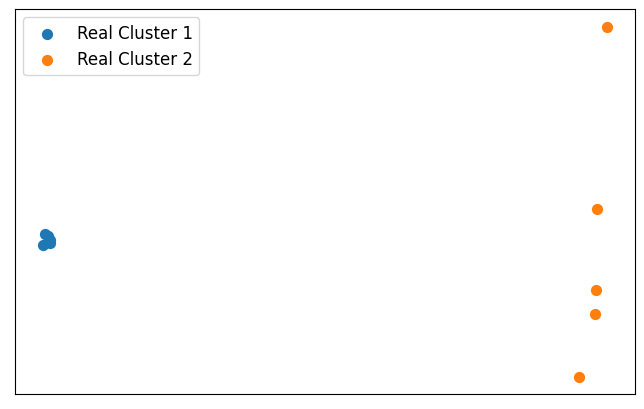

silhouette: 0.8459938168525696, ari: 1.0
cluster_count: 4, class_per_cluster: 2
Epoch 5 - Train Loss: 1.8527, Train Accuracy: 81.43%, Eval Accuracy: 100.00%
Epoch 10 - Train Loss: 0.8733, Train Accuracy: 80.00%, Eval Accuracy: 90.00%
Epoch 15 - Train Loss: 0.5541, Train Accuracy: 91.43%, Eval Accuracy: 96.67%
Epoch 20 - Train Loss: 0.4111, Train Accuracy: 91.43%, Eval Accuracy: 100.00%
Epoch 25 - Train Loss: 0.2745, Train Accuracy: 91.43%, Eval Accuracy: 100.00%
Epoch 30 - Train Loss: 0.1835, Train Accuracy: 92.86%, Eval Accuracy: 96.67%
Global Logit's Accuracy: 53.34%
label_predicted:          0       1       2       3       4       5       6       7    8    9
0   2184.0  2816.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  0.0
1   3383.0  1617.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  0.0
2   2152.0  2848.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  0.0
3   3170.0  1830.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  0.0
4   3153.0  1847.0    

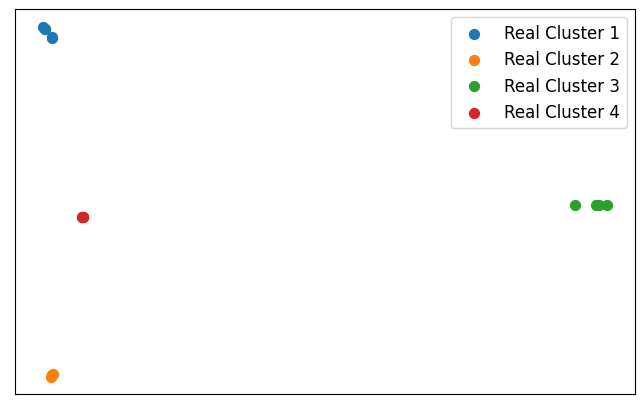

silhouette: 0.8758937120437622, ari: 1.0
cluster_count: 4, class_per_cluster: 3
Epoch 5 - Train Loss: 2.0921, Train Accuracy: 38.10%, Eval Accuracy: 33.33%
Epoch 10 - Train Loss: 1.4442, Train Accuracy: 33.33%, Eval Accuracy: 33.33%
Epoch 15 - Train Loss: 0.9951, Train Accuracy: 72.38%, Eval Accuracy: 66.67%
Epoch 20 - Train Loss: 0.8670, Train Accuracy: 96.19%, Eval Accuracy: 86.67%
Epoch 25 - Train Loss: 0.6909, Train Accuracy: 79.05%, Eval Accuracy: 88.89%
Epoch 30 - Train Loss: 0.4849, Train Accuracy: 90.48%, Eval Accuracy: 84.44%
Global Logit's Accuracy: 40.74%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   1003.0   892.0  3105.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   1248.0  1522.0  2230.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   1193.0  1187.0  2620.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   1459.0  1332.0  2209.0     0.0     0.0     0.0     0.0     0.0     0.0   
4   2140.0   938.0  

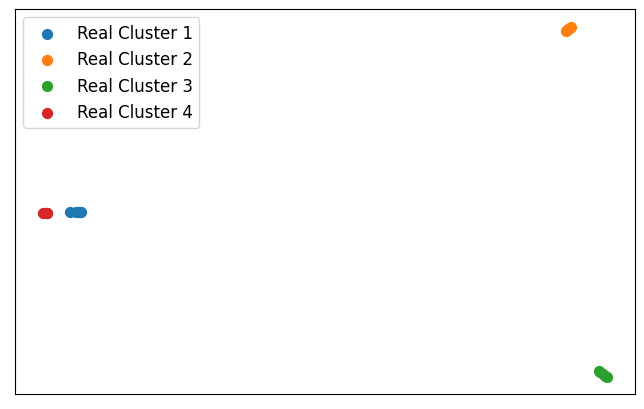

silhouette: 0.8300769925117493, ari: 1.0
cluster_count: 4, class_per_cluster: 4
Epoch 5 - Train Loss: 1.6910, Train Accuracy: 39.29%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 1.3590, Train Accuracy: 25.00%, Eval Accuracy: 25.00%
Epoch 15 - Train Loss: 1.0334, Train Accuracy: 76.43%, Eval Accuracy: 71.67%
Epoch 20 - Train Loss: 0.8711, Train Accuracy: 69.29%, Eval Accuracy: 70.00%
Epoch 25 - Train Loss: 0.4439, Train Accuracy: 80.71%, Eval Accuracy: 83.33%
Epoch 30 - Train Loss: 0.1968, Train Accuracy: 95.71%, Eval Accuracy: 93.33%
Global Logit's Accuracy: 55.78%
label_predicted:          0      1       2       3       4       5       6       7       8  \
0   1439.0  606.0  2279.0   676.0     0.0     0.0     0.0     0.0     0.0   
1   1712.0  997.0   773.0  1518.0     0.0     0.0     0.0     0.0     0.0   
2   1194.0  691.0  2260.0   855.0     0.0     0.0     0.0     0.0     0.0   
3   1217.0  575.0   875.0  2333.0     0.0     0.0     0.0     0.0     0.0   
4    591.0  682.0  1617.0

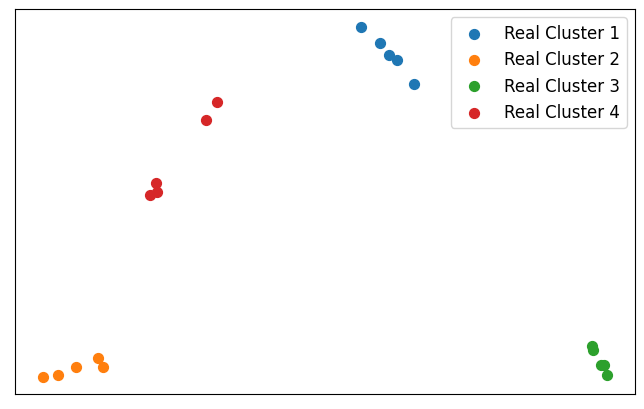

silhouette: 0.5832685232162476, ari: 1.0
cluster_count: 4, class_per_cluster: 5
Epoch 5 - Train Loss: 1.7427, Train Accuracy: 20.00%, Eval Accuracy: 20.00%
Epoch 10 - Train Loss: 1.3957, Train Accuracy: 45.71%, Eval Accuracy: 53.33%
Epoch 15 - Train Loss: 1.0547, Train Accuracy: 79.43%, Eval Accuracy: 70.67%
Epoch 20 - Train Loss: 0.6491, Train Accuracy: 84.57%, Eval Accuracy: 78.67%
Epoch 25 - Train Loss: 0.3989, Train Accuracy: 86.86%, Eval Accuracy: 81.33%
Global Logit's Accuracy: 70.22%
label_predicted:         0      1       2       3       4       5      6      7       8       9
0   973.0  558.0   903.0  1388.0  1178.0     0.0    0.0    0.0     0.0     0.0
1   786.0  803.0   876.0  1456.0  1079.0     0.0    0.0    0.0     0.0     0.0
2   649.0  608.0  1022.0  1079.0  1642.0     0.0    0.0    0.0     0.0     0.0
3   949.0  640.0   632.0  1273.0  1506.0     0.0    0.0    0.0     0.0     0.0
4   660.0  870.0   869.0  1131.0  1470.0     0.0    0.0    0.0     0.0     0.0
5     0.0    

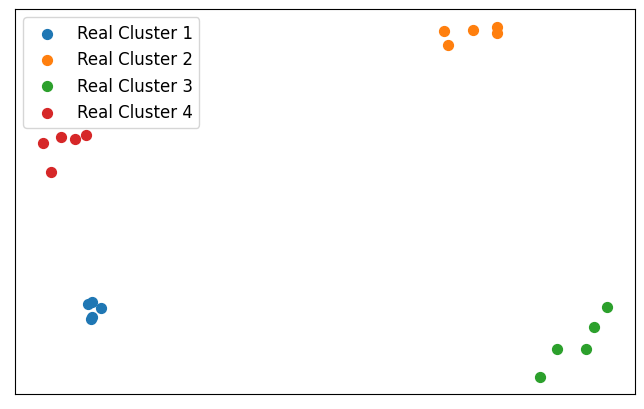

silhouette: 0.7813326120376587, ari: 1.0
cluster_count: 6, class_per_cluster: 2
Epoch 5 - Train Loss: 1.9955, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 1.1783, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 15 - Train Loss: 0.6379, Train Accuracy: 75.71%, Eval Accuracy: 83.33%
Epoch 20 - Train Loss: 0.5412, Train Accuracy: 91.43%, Eval Accuracy: 93.33%
Epoch 25 - Train Loss: 0.4362, Train Accuracy: 92.86%, Eval Accuracy: 90.00%
Epoch 30 - Train Loss: 0.3184, Train Accuracy: 94.29%, Eval Accuracy: 90.00%
Global Logit's Accuracy: 18.70%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   3083.0  1917.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   3851.0  1149.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   3299.0  1701.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   2999.0  2001.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4   3204.0  1796.0  

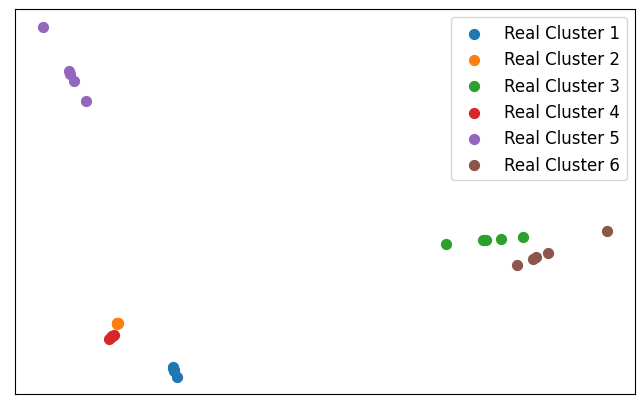

silhouette: 0.8095096945762634, ari: 1.0
cluster_count: 6, class_per_cluster: 3
Epoch 5 - Train Loss: 1.9826, Train Accuracy: 33.33%, Eval Accuracy: 33.33%
Epoch 10 - Train Loss: 1.3071, Train Accuracy: 33.33%, Eval Accuracy: 33.33%
Epoch 15 - Train Loss: 1.0126, Train Accuracy: 65.71%, Eval Accuracy: 60.00%
Epoch 20 - Train Loss: 0.8998, Train Accuracy: 82.86%, Eval Accuracy: 60.00%
Epoch 25 - Train Loss: 0.7653, Train Accuracy: 69.52%, Eval Accuracy: 68.89%
Epoch 30 - Train Loss: 0.5842, Train Accuracy: 96.19%, Eval Accuracy: 84.44%
Global Logit's Accuracy: 65.76%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   1771.0  1105.0  2124.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    958.0  1742.0  2300.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   1717.0  1177.0  2106.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   1444.0  1223.0  2333.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    881.0  1091.0  

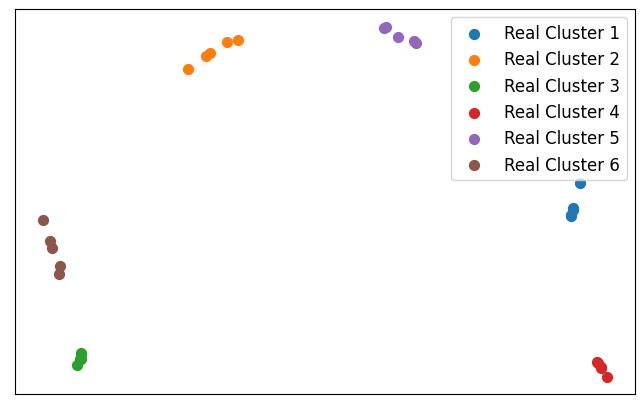

silhouette: 0.7739802598953247, ari: 1.0
cluster_count: 6, class_per_cluster: 4
Epoch 5 - Train Loss: 1.8505, Train Accuracy: 25.00%, Eval Accuracy: 25.00%
Epoch 10 - Train Loss: 1.2388, Train Accuracy: 75.00%, Eval Accuracy: 36.67%
Epoch 15 - Train Loss: 0.9461, Train Accuracy: 75.00%, Eval Accuracy: 86.67%
Epoch 20 - Train Loss: 0.5718, Train Accuracy: 84.29%, Eval Accuracy: 90.00%
Epoch 25 - Train Loss: 0.2494, Train Accuracy: 97.14%, Eval Accuracy: 91.67%
Epoch 30 - Train Loss: 0.1680, Train Accuracy: 97.86%, Eval Accuracy: 95.00%
Global Logit's Accuracy: 73.52%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0    764.0   994.0  1464.0  1778.0     0.0     0.0     0.0     0.0     0.0   
1   1393.0  1060.0  1209.0  1338.0     0.0     0.0     0.0     0.0     0.0   
2    935.0   763.0  1074.0  2228.0     0.0     0.0     0.0     0.0     0.0   
3   1124.0   594.0   653.0  2629.0     0.0     0.0     0.0     0.0     0.0   
4    717.0   608.0  

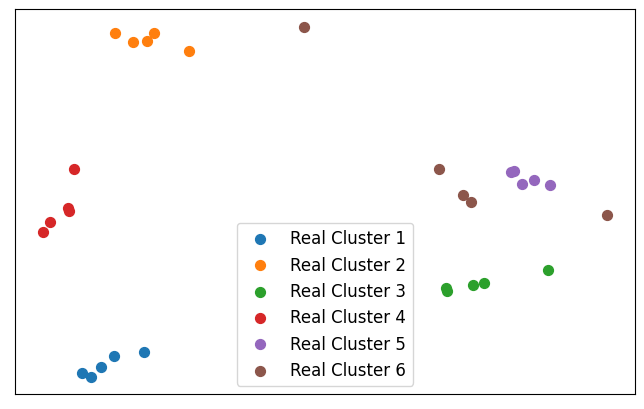

silhouette: 0.5191075205802917, ari: 0.7913669064748201
cluster_count: 6, class_per_cluster: 5
Epoch 5 - Train Loss: 1.8251, Train Accuracy: 29.14%, Eval Accuracy: 20.00%
Epoch 10 - Train Loss: 1.3777, Train Accuracy: 67.43%, Eval Accuracy: 48.00%
Epoch 15 - Train Loss: 1.0267, Train Accuracy: 79.43%, Eval Accuracy: 73.33%
Epoch 20 - Train Loss: 0.6186, Train Accuracy: 85.14%, Eval Accuracy: 78.67%
Epoch 25 - Train Loss: 0.3753, Train Accuracy: 87.43%, Eval Accuracy: 86.67%
Epoch 30 - Train Loss: 0.3189, Train Accuracy: 90.29%, Eval Accuracy: 90.67%
Global Logit's Accuracy: 62.00%
label_predicted:          0      1       2       3       4       5       6      7       8  \
0   1023.0  535.0   918.0  1098.0  1426.0     0.0     0.0    0.0     0.0   
1    540.0  630.0  1281.0  1310.0  1239.0     0.0     0.0    0.0     0.0   
2    612.0  757.0  1136.0  1241.0  1254.0     0.0     0.0    0.0     0.0   
3   1020.0  545.0   826.0  1283.0  1326.0     0.0     0.0    0.0     0.0   
4   1004.0  850

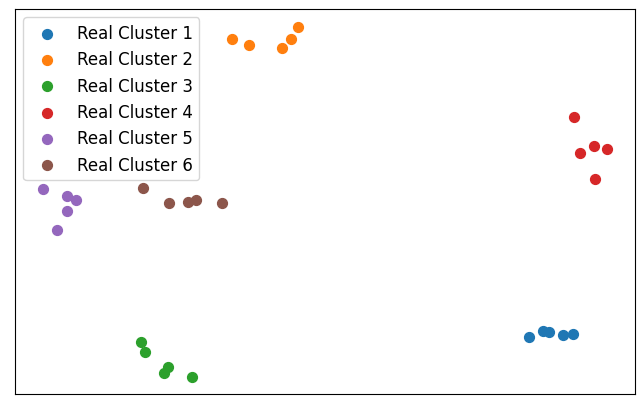

silhouette: 0.7503449320793152, ari: 1.0
cluster_count: 8, class_per_cluster: 2
Epoch 5 - Train Loss: 1.9852, Train Accuracy: 85.71%, Eval Accuracy: 93.33%
Epoch 10 - Train Loss: 0.9255, Train Accuracy: 88.57%, Eval Accuracy: 96.67%
Epoch 15 - Train Loss: 0.5531, Train Accuracy: 92.86%, Eval Accuracy: 96.67%
Epoch 20 - Train Loss: 0.4286, Train Accuracy: 94.29%, Eval Accuracy: 96.67%
Epoch 25 - Train Loss: 0.2853, Train Accuracy: 95.71%, Eval Accuracy: 96.67%
Epoch 30 - Train Loss: 0.1783, Train Accuracy: 94.29%, Eval Accuracy: 93.33%
Global Logit's Accuracy: 49.70%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   2532.0  2468.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   3497.0  1503.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   3097.0  1903.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   2288.0  2712.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4   3114.0  1886.0  

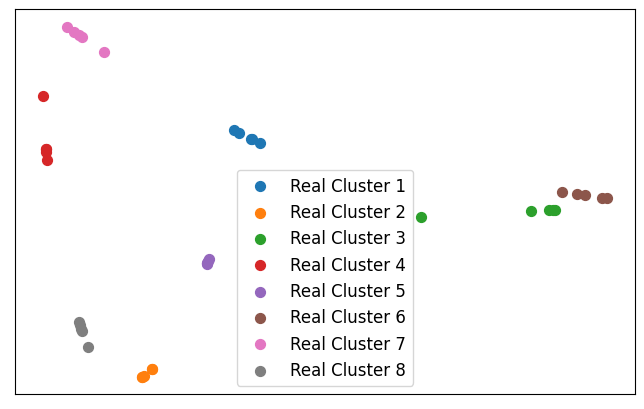

silhouette: 0.7854129076004028, ari: 1.0
cluster_count: 8, class_per_cluster: 3
Epoch 5 - Train Loss: 2.0798, Train Accuracy: 66.67%, Eval Accuracy: 66.67%
Epoch 10 - Train Loss: 1.4326, Train Accuracy: 72.38%, Eval Accuracy: 73.33%
Epoch 15 - Train Loss: 0.9729, Train Accuracy: 84.76%, Eval Accuracy: 82.22%
Epoch 20 - Train Loss: 0.8133, Train Accuracy: 89.52%, Eval Accuracy: 80.00%
Epoch 25 - Train Loss: 0.6001, Train Accuracy: 92.38%, Eval Accuracy: 86.67%
Epoch 30 - Train Loss: 0.3840, Train Accuracy: 94.29%, Eval Accuracy: 88.89%
Global Logit's Accuracy: 52.54%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   1531.0  1370.0  2099.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   1034.0   839.0  3127.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   1024.0  1256.0  2720.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   1802.0   971.0  2227.0     0.0     0.0     0.0     0.0     0.0     0.0   
4   2248.0  1152.0  

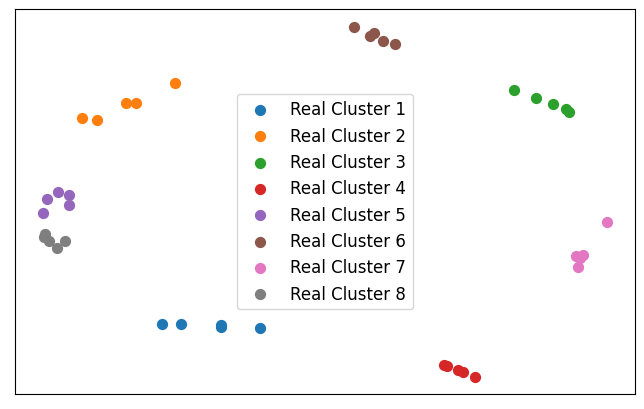

silhouette: 0.6939748525619507, ari: 1.0
cluster_count: 8, class_per_cluster: 4
Epoch 5 - Train Loss: 1.7764, Train Accuracy: 25.00%, Eval Accuracy: 25.00%
Epoch 10 - Train Loss: 1.1552, Train Accuracy: 78.57%, Eval Accuracy: 40.00%
Epoch 15 - Train Loss: 0.8951, Train Accuracy: 57.14%, Eval Accuracy: 85.00%
Epoch 20 - Train Loss: 0.4196, Train Accuracy: 93.57%, Eval Accuracy: 88.33%
Epoch 25 - Train Loss: 0.2136, Train Accuracy: 95.71%, Eval Accuracy: 86.67%
Global Logit's Accuracy: 66.32%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0    600.0   971.0  1029.0  2400.0     0.0     0.0     0.0     0.0     0.0   
1   1604.0   699.0   927.0  1770.0     0.0     0.0     0.0     0.0     0.0   
2   1402.0   584.0  2183.0   831.0     0.0     0.0     0.0     0.0     0.0   
3    620.0   794.0  1271.0  2315.0     0.0     0.0     0.0     0.0     0.0   
4    475.0   639.0  1403.0  2483.0     0.0     0.0     0.0     0.0     0.0   
5      0.0     0.0 

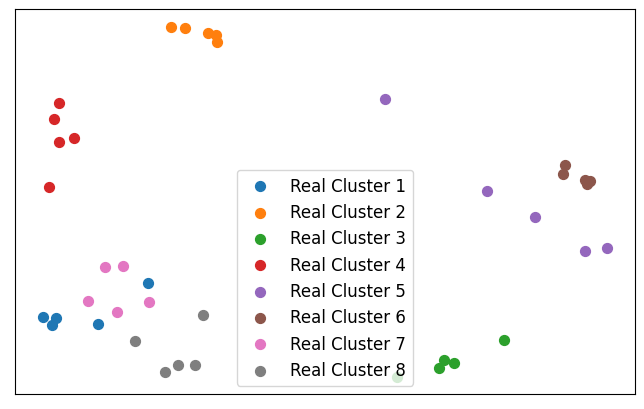

silhouette: 0.5871667265892029, ari: 0.8909853249475891
cluster_count: 8, class_per_cluster: 5
Epoch 5 - Train Loss: 1.8644, Train Accuracy: 37.71%, Eval Accuracy: 32.00%
Epoch 10 - Train Loss: 1.4095, Train Accuracy: 38.86%, Eval Accuracy: 50.67%
Epoch 15 - Train Loss: 1.0723, Train Accuracy: 71.43%, Eval Accuracy: 68.00%
Epoch 20 - Train Loss: 0.6889, Train Accuracy: 83.43%, Eval Accuracy: 80.00%
Epoch 25 - Train Loss: 0.4337, Train Accuracy: 89.14%, Eval Accuracy: 81.33%
Epoch 30 - Train Loss: 0.2912, Train Accuracy: 91.43%, Eval Accuracy: 84.00%
Global Logit's Accuracy: 80.42%
label_predicted:          0      1       2       3       4       5       6       7       8  \
0    775.0  702.0   933.0  1016.0  1574.0     0.0     0.0     0.0     0.0   
1    618.0  667.0   994.0  1340.0  1381.0     0.0     0.0     0.0     0.0   
2    767.0  750.0   645.0  1270.0  1568.0     0.0     0.0     0.0     0.0   
3    642.0  758.0   836.0  1390.0  1374.0     0.0     0.0     0.0     0.0   
4    746.0

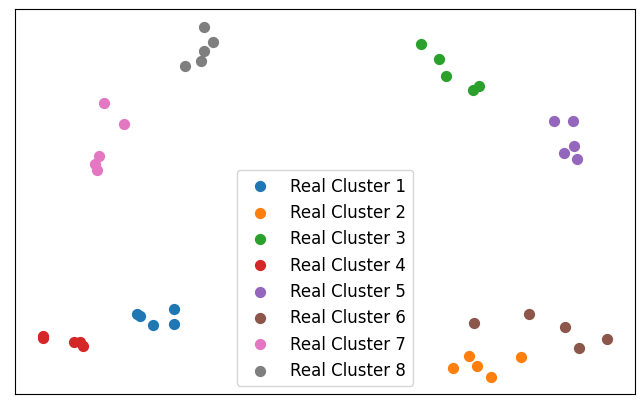

silhouette: 0.7381702065467834, ari: 1.0
cluster_count: 10, class_per_cluster: 2
Epoch 5 - Train Loss: 1.8221, Train Accuracy: 51.43%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 0.9040, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 15 - Train Loss: 0.6269, Train Accuracy: 60.00%, Eval Accuracy: 50.00%
Epoch 20 - Train Loss: 0.5457, Train Accuracy: 77.14%, Eval Accuracy: 90.00%
Epoch 25 - Train Loss: 0.4260, Train Accuracy: 94.29%, Eval Accuracy: 93.33%
Epoch 30 - Train Loss: 0.3311, Train Accuracy: 91.43%, Eval Accuracy: 90.00%
Global Logit's Accuracy: 52.98%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   3447.0  1553.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   3145.0  1855.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   3406.0  1594.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   2085.0  2915.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4   3211.0  1789.0 

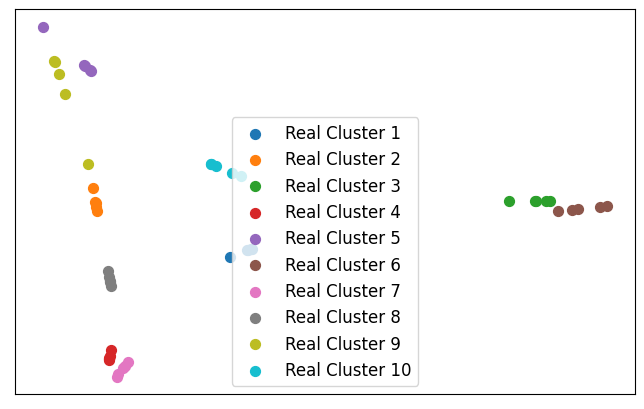

silhouette: 0.7513179183006287, ari: 0.9512222099325296
cluster_count: 10, class_per_cluster: 3
Epoch 5 - Train Loss: 2.1712, Train Accuracy: 33.33%, Eval Accuracy: 33.33%
Epoch 10 - Train Loss: 1.6833, Train Accuracy: 35.24%, Eval Accuracy: 33.33%
Epoch 15 - Train Loss: 1.1248, Train Accuracy: 44.76%, Eval Accuracy: 60.00%
Epoch 20 - Train Loss: 1.0155, Train Accuracy: 52.38%, Eval Accuracy: 71.11%
Epoch 25 - Train Loss: 0.9314, Train Accuracy: 87.62%, Eval Accuracy: 73.33%
Epoch 30 - Train Loss: 0.7997, Train Accuracy: 92.38%, Eval Accuracy: 88.89%
Global Logit's Accuracy: 73.46%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   1540.0   834.0  2626.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    805.0   880.0  3315.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   1648.0  1028.0  2324.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   1235.0  2101.0  1664.0     0.0     0.0     0.0     0.0     0.0     0.0   
4   

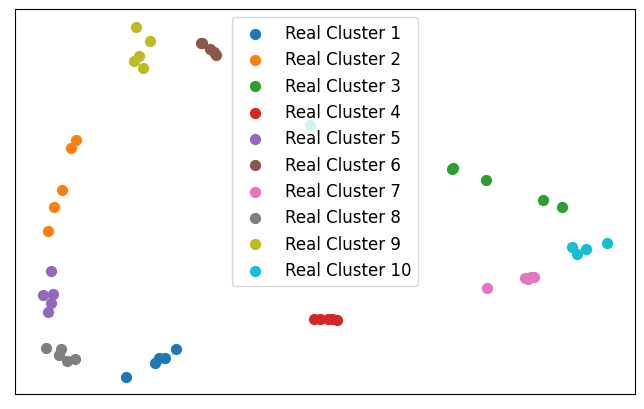

silhouette: 0.5681665539741516, ari: 0.8782104391052196
cluster_count: 10, class_per_cluster: 4
Epoch 5 - Train Loss: 1.6723, Train Accuracy: 42.86%, Eval Accuracy: 25.00%
Epoch 10 - Train Loss: 1.2701, Train Accuracy: 80.71%, Eval Accuracy: 46.67%
Epoch 15 - Train Loss: 1.0705, Train Accuracy: 59.29%, Eval Accuracy: 75.00%
Epoch 20 - Train Loss: 0.7014, Train Accuracy: 83.57%, Eval Accuracy: 83.33%
Epoch 25 - Train Loss: 0.4104, Train Accuracy: 90.00%, Eval Accuracy: 88.33%
Epoch 30 - Train Loss: 0.2712, Train Accuracy: 90.00%, Eval Accuracy: 95.00%
Global Logit's Accuracy: 80.94%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0    578.0   609.0  1344.0  2469.0     0.0     0.0     0.0     0.0     0.0   
1   1412.0   568.0  1178.0  1842.0     0.0     0.0     0.0     0.0     0.0   
2    730.0   595.0   988.0  2687.0     0.0     0.0     0.0     0.0     0.0   
3   1041.0   669.0   917.0  2373.0     0.0     0.0     0.0     0.0     0.0   
4   

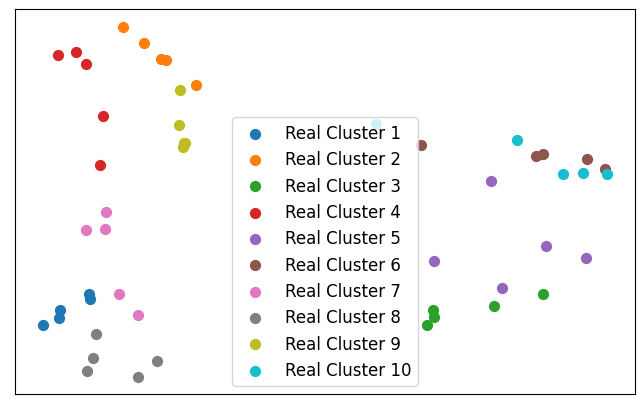

silhouette: 0.5349999070167542, ari: 1.0
cluster_count: 10, class_per_cluster: 5
Epoch 5 - Train Loss: 1.9074, Train Accuracy: 20.00%, Eval Accuracy: 20.00%
Epoch 10 - Train Loss: 1.5072, Train Accuracy: 33.14%, Eval Accuracy: 42.67%
Epoch 15 - Train Loss: 1.2031, Train Accuracy: 78.29%, Eval Accuracy: 78.67%
Epoch 20 - Train Loss: 0.8122, Train Accuracy: 85.14%, Eval Accuracy: 82.67%
Epoch 25 - Train Loss: 0.5292, Train Accuracy: 85.14%, Eval Accuracy: 85.33%
Epoch 30 - Train Loss: 0.3560, Train Accuracy: 89.14%, Eval Accuracy: 88.00%
Global Logit's Accuracy: 79.24%
label_predicted:          0       1       2       3       4       5       6       7       8  \
0    884.0   618.0  1146.0  1280.0  1072.0     0.0     0.0     0.0     0.0   
1    624.0   555.0  1190.0  1310.0  1321.0     0.0     0.0     0.0     0.0   
2    665.0   604.0  1182.0  1331.0  1218.0     0.0     0.0     0.0     0.0   
3    903.0   789.0   841.0  1145.0  1322.0     0.0     0.0     0.0     0.0   
4    761.0   972.0 

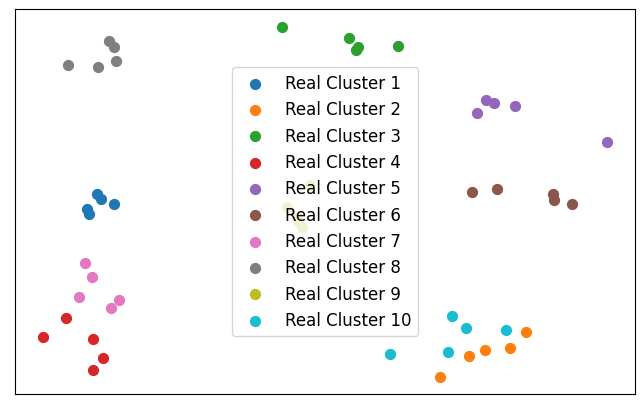

silhouette: 0.7200585007667542, ari: 1.0


In [9]:
# Initialize empty DataFrames to store results with multi-level columns
multi_col = pd.MultiIndex.from_product([range(2, 6), ['silhouette', 'ari']], names=['class per cluster', 'cluster number'])
clustering_acc = pd.DataFrame(columns=multi_col)

# Iterate over different cluster_count values
for cluster_count in [2, 4, 6, 8, 10]:
    # Iterate over different class_per_cluster values
    for class_per_cluster in range(2, 6):
        n_clients = cluster_count * 5
        instances_per_class_per_client = get_combination(cluster_count, class_per_cluster)
        print(f'cluster_count: {cluster_count}, class_per_cluster: {class_per_cluster}')
        # Replace with your actual cluster_train_result_exp functio
        silhouette, ari = clustering_exp(
        n_clients, 50000, 5000, cluster_count, [1/cluster_count] * cluster_count, 50, instances_per_class_per_client
    )     
        # Update DataFrame
        clustering_acc.loc[cluster_count, (class_per_cluster, 'silhouette')] = silhouette
        clustering_acc.loc[cluster_count, (class_per_cluster, 'ari')] = ari

In [13]:
clustering_acc.to_csv('./results/clustering_exp_ours')

In [10]:
df_client_accs.to_csv('./results/Second Experiment')

NameError: name 'df_client_accs' is not defined

In [ ]:
df_client_accs

In [ ]:
filtered_df = df_client_accs.iloc[:,3:]

In [ ]:
filtered_df

In [ ]:
filtered_df.to_csv('./results/Second Experiment/filtered')

In [ ]:
for class_per_cluster in range(2, 6):
    filtered_df.loc[:, (class_per_cluster, 'difference')] = filtered_df.loc[:, (class_per_cluster, 'cluster_distill')] - filtered_df.loc[:, (class_per_cluster, 'global_distill')]


In [ ]:
second_exp = filtered_df#.iloc[:,-4:]
second_exp *= 100
print(second_exp)

In [ ]:
second_exp_latex = second_exp.style.to_latex()
print(second_exp_latex)

In [ ]:
latex_table = filtered_df.style.to_latex()
print(latex_table)

In [ ]:
df_client_accs.mean()

In [ ]:
df_mean = df_client_accs.mean()
df_mean = df_mean.reset_index()
df_mean.columns = ['class_per_cluster', 'Metric', 'Value']

# Pivot the table so Metrics become columns
df_pivot = df_mean.pivot(index='class_per_cluster', columns='Metric', values='Value')

# Create a new feature
df_pivot['cluster_global_diff'] = df_pivot['cluster_distill'] - df_pivot['global_distill']

# Reset the index for the final DataFrame
df_pivot.reset_index(inplace=True)
df_pivot_filtered = df_pivot.iloc[1:]

plt.bar(df_pivot_filtered['class_per_cluster'], df_pivot_filtered['cluster_global_diff'])
plt.xlabel('Class Per Cluster')
plt.ylabel('Cluster Global Difference')
plt.title('Bar Graph of Cluster Global Difference by Class Per Cluster')
xticks = np.arange(min(df_pivot_filtered['class_per_cluster']), max(df_pivot_filtered['class_per_cluster']) + 1)
xticks = [tick for tick in xticks if tick >= 0]  # Remove negative numbers, if any
plt.xticks(xticks)

plt.show()


In [ ]:
df_global_accs

In [ ]:
def Global_TC_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution, data_per_class_3, data_per_class_7)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # # 0. Representational Learning
    # for i, client in enumerate(clients):
    #     Total_data = CustomSubset(data, np.concatenate((server_idcs, client_idcs[i])), transforms.Compose([transforms.ToTensor()]))
    #     # print(f'data used to trian representation: {len(Total_data)}')
    #     client.learn_representation(Total_data)
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
    
    # 2. get cluster loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))
    

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%") 
    
    
     # 4. Distillation
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [ ]:
# TC_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3], 117, 21)

In [ ]:
clustering_by_model_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3], 100, 0)

In [ ]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
date_time = now.strftime("%m%d_%H%M")

columns = pd.MultiIndex.from_product([['client_accs', 'cluster_accs', 'global_accs'], ['before_distill', 'after_distill']],
                                     names=['acc_type', 'distill_state'])

desired_pairs = [(50000, 5000)]
cluster_distribution = [1/3, 1/3, 1/3]
experiments = ['cluster_distill', 'sim', 'global_distill']
index = pd.MultiIndex.from_product([experiments, desired_pairs], names=['experiment', 'data_pair'])

df = pd.DataFrame(index=index, columns=columns)
runs = 2  # number of times each experiment should be run

for exp in experiments:
    for pair in desired_pairs:
        total_client_accs = [0, 0]
        total_cluster_accs = [0, 0]
        total_global_accs = [0, 0]

        for _ in range(runs):
            client_data, distill_data = pair

            if exp == 'sim':
                client_accs, cluster_accs, global_accs = SimCLR_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
            elif exp == 'global_distill':
                client_accs, cluster_accs, global_accs = global_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
            else:
                client_accs, cluster_accs, global_accs = four_class_classification_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)

            total_client_accs = [x+y for x, y in zip(total_client_accs, [client_accs[-2], client_accs[-1]])]
            total_cluster_accs = [x+y for x, y in zip(total_cluster_accs, [cluster_accs[-2], cluster_accs[-1]])]
            total_global_accs = [x+y for x, y in zip(total_global_accs, [global_accs[-2], global_accs[-1]])]

        avg_client_accs = [x/runs for x in total_client_accs]
        avg_cluster_accs = [x/runs for x in total_cluster_accs]
        avg_global_accs = [x/runs for x in total_global_accs]

        df.loc[(exp, pair), ('client_accs', 'before_distill')] = avg_client_accs[0]
        df.loc[(exp, pair), ('client_accs', 'after_distill')] = avg_client_accs[1]
        df.loc[(exp, pair), ('global_accs', 'before_distill')] = avg_global_accs[0]
        df.loc[(exp, pair), ('global_accs', 'after_distill')] = avg_global_accs[1]
        df.loc[(exp, pair), ('cluster_accs', 'before_distill')] = avg_cluster_accs[0]
        df.loc[(exp, pair), ('cluster_accs', 'after_distill')] = avg_cluster_accs[1]

directory = f'results/SimCLR'
if not os.path.exists(directory):
    os.makedirs(directory)
cluster_distribution_str = "_".join(map(str, cluster_distribution))
file_name = f'{directory}/client:{N_CLIENTS}_cluster:{NUMBER_OF_CLUSTER}_distribution:{cluster_distribution_str}_{date_time}.csv'
df = df.round(decimals=3)
df.to_csv(file_name)

In [ ]:
df = pd.read_csv('results/global_distill/CIFAR_0720_0435.csv', index_col=[0,1], header=[0,1])

# 그릴 데이터와 제목을 리스트로 저장
heatmap_data = [('client_accs', 'change_after_distill', 'Client Accuracy change after Distillation'),
                ('global_accs', 'change_after_distill', 'Global Accuracy change after Distillation')]

# Compute change in accuracy
df[('client_accs', 'change_after_distill')] = df[('client_accs', 'after_distill')] - df[('client_accs', 'before_distill')]
df[('global_accs', 'change_after_distill')] = df[('global_accs', 'after_distill')] - df[('global_accs', 'before_distill')]

# 전체 데이터의 최솟값, 최댓값 계산
vmin = min(df[data1][data2].min() for data1, data2, _ in heatmap_data)
vmax = max(df[data1][data2].max() for data1, data2, _ in heatmap_data)

for data1, data2, title in heatmap_data:
    plt.figure(figsize=(9, 5))
    sns.heatmap(df[(data1, data2)].unstack(), annot=True, cmap='coolwarm', center=0, vmin=-0.1, vmax=0.2)
    plt.title(title)
    plt.show()


## 2.Clustering 실험

In [ ]:
def do_clustering_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA=ALPHA):
    train_idcs, test_idcs = idcs[:int(total_client_data*10)], idcs[int(total_client_data*10):]
    train_labels = data.train_labels.numpy()
    test_labels = data.train_labels.numpy()[int(total_client_data*10):]

    client_idcs = split_noniid(train_idcs, train_labels, alpha=ALPHA, n_clients=N_CLIENTS)#, data_per_class=int(total_client_data/10))
    # server_idcs = generate_server_idcs(test_idcs, test_labels, int(total_client_data*10))

    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(resnet18, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)

    
    distillation_data_file = f'distillation_data_{data_per_class}_per_class.pth'

    # Check if the file already exists
    if not os.path.exists(distillation_data_file):
        # The file does not exist, generate and save the distillation data
        distillation_data = server.make_distillation_data(data_per_class=data_per_class)
        torch.save(distillation_data, distillation_data_file)

    # Load the distillation data
    distillation_data = torch.load(distillation_data_file)

    clients = [Client(resnet18, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, i, distillation_data) 
               for i, dat in enumerate(client_data)]

    def aggregate(cluster_indices_new):
        cluster_indices = cluster_indices_new
        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

        server.aggregate_clusterwise(client_clusters)

        return cluster_indices

    cfl_stats = ExperimentLogger()

    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


    for epoch in range(1, LOCAL_EPOCHS+1):

        if epoch == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            if epoch == 1:
                client.distill()

            train_stats = client.compute_weight_update(epochs=1) #train client

            if epoch == 1000:
                client.reset()

        cluster_indices_new = []

        for idc in cluster_indices:
            max_norm = server.compute_max_update_norm([clients[i] for i in idc])
            mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

            #cluster 나누는 기준
            if epoch == LOCAL_EPOCHS: #무조건 한번 나누기
                similarities = server.compute_pairwise_similarities(clients)

                server.cache_model(idc, clients[idc[0]].W, acc_clients)

                c1, c2, c3 = server.cluster_clients_GMM(similarities[idc][:,idc])
                cluster_indices_new += [c1, c2, c3]

        if epoch == 1000:
            cluster_indices = aggregate(cluster_indices_new)

        acc_clients = [client.evaluate() for client in clients]

        if epoch == LOCAL_EPOCHS: #무조건 한번 나누기
            label_accuracies = pd.DataFrame()
            label_predicted = pd.DataFrame()
            label_soft_sum = pd.DataFrame()
            label_diff = pd.DataFrame()

            for i, client in enumerate(clients):
                acc, pred, sum_, diff = server.evaluate(client.model)
                # Convert each dictionary to a DataFrame and append to the respective DataFrame
                label_accuracies = label_accuracies.append(pd.DataFrame(acc, index=[i]))
                label_predicted = label_predicted.append(pd.DataFrame(pred, index=[i]))
                label_soft_sum = label_soft_sum.append(pd.DataFrame(sum_, index=[i]))
                label_diff = label_diff.append(pd.DataFrame(diff, index=[i]))

            # Reset index for all DataFrames
            label_accuracies.reset_index(drop=True, inplace=True)
            label_predicted.reset_index(drop=True, inplace=True)
            label_soft_sum.reset_index(drop=True, inplace=True)
            label_diff.reset_index(drop=True, inplace=True)

        if epoch == 1:
            first_accuracies = pd.DataFrame()
            for i, client in enumerate(clients):
                first_acc, pred, sum_, diff = server.evaluate(client.model)
                first_accuracies = pd.concat([first_accuracies, pd.DataFrame(first_acc, index=[i])])
            first_accuracies = first_accuracies.fillna(0)

            client_acc_after_distill = sum(acc_clients)/len(acc_clients)
            global_acc_after_distill = np.mean(np.ravel(first_accuracies.values))


        elif epoch == LOCAL_EPOCHS:
            client_acc_final = sum(acc_clients)/len(acc_clients)
            global_acc_final = np.mean(np.ravel(label_accuracies.values))

        average_dw = server.get_average_dw(clients)
        #print(average_dw)
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                      "rounds" : epoch, "clusters" : cluster_indices, "average_dw": average_dw})


        display_train_stats(cfl_stats, EPS_1, EPS_2, LOCAL_EPOCHS)


    for idc in cluster_indices:    
        server.cache_model(idc, clients[idc[0]].W, acc_clients)
    
    client_acc_after_distill = round(client_acc_after_distill, 3)
    global_acc_after_distill = round(global_acc_after_distill, 3)
    client_acc_final = round(client_acc_final, 3)
    global_acc_final = round(global_acc_final, 3)
    
    return client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final

    print(client_acc_after_distill, global_acc_after_distill)
    print(client_acc_final, global_acc_final)

In [ ]:
first_accuracies

In [ ]:
label_accuracies.sort_index(axis=1)

In [ ]:
label_soft_sum.sort_index(axis=1)

In [ ]:
label_diff.sort_index(axis=1)

In [ ]:
label_predicted.sort_index(axis=1)

In [ ]:
from sklearn.decomposition import PCA
# Instantiate PCA
pca = PCA(n_components=2)

# Apply PCA to the dataframes
label_accuracies_pca = pca.fit_transform(label_accuracies)
label_predicted_pca = pca.fit_transform(label_predicted)
label_soft_sum_pca = pca.fit_transform(label_soft_sum)
label_diff_pca = pca.fit_transform(label_diff)
transformed_data = pca.fit_transform(similarities)

# Create labels
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plots with larger dots
dot_size = 50
axs[0, 0].scatter(label_accuracies_pca[:, 0], label_accuracies_pca[:, 1], c=labels, s=dot_size)
axs[0, 0].set_title('Label Accuracies')
axs[0, 1].scatter(label_predicted_pca[:, 0], label_predicted_pca[:, 1], c=labels, s=dot_size)
axs[0, 1].set_title('Label Predicted')
axs[1, 0].scatter(label_soft_sum_pca[:, 0], label_soft_sum_pca[:, 1], c=labels, s=dot_size)
axs[1, 0].set_title('Label Soft Sum')
axs[1, 1].scatter(label_diff_pca[:, 0], label_diff_pca[:, 1], c=labels, s=dot_size)
axs[1, 1].set_title('Label Soft Diff')

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
silhouette_accuracies = silhouette_score(label_accuracies_pca, labels)
silhouette_predicted = silhouette_score(label_predicted_pca, labels)
silhouette_soft_sum = silhouette_score(label_soft_sum_pca, labels)
silhouette_diff = silhouette_score(label_diff_pca, labels)
silhouette_transformed_data = silhouette_score(transformed_data, labels)

print('Silhouette Score for Accuracies:', silhouette_accuracies)
print('Silhouette Score for Predicted:', silhouette_predicted)
print('Silhouette Score for Soft Sum:', silhouette_soft_sum)
print('Silhouette Score for diff:', silhouette_diff)
print('Silhouette Score for Model params:', silhouette_transformed_data)



In [ ]:
#df.sort_index(axis=1)

데이터 Cluster 별 모델 파라미터 분포

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit and transform your data to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(similarities)

# Assign labels based on index ranges
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 0.35, len(unique_labels)))

# Plot the transformed data with labels
for label, color in zip(unique_labels, colors):
    idx = np.where(labels == label)
    plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], color=color, label=f'Cluster {label}')

# Add a legend
plt.legend()

plt.show()
